In [13]:
# =============================================================================
# 0) Install dependencies
# =============================================================================
!pip install -q \
  torch torchvision torchaudio \
  lime shap xgboost captum scikit-learn scikit-image \
  git+https://github.com/jacobgil/pytorch-grad-cam.git \
  matplotlib seaborn tqdm pillow

# =============================================================================
# 1) Imports & Seeding
# =============================================================================
# Core Python modules
import os
import zipfile
import random
import warnings
import math
from collections import defaultdict

# Scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

# Sklearn for metrics and data split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Progress bar
from tqdm import tqdm

# Explainability libraries
from lime import lime_image
from skimage.segmentation import mark_boundaries
from captum.attr import Occlusion, visualization as viz
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# SHAP and XGBoost (optional for tabular explainability)
import shap
import xgboost as xgb

# Suppress warnings
warnings.filterwarnings("ignore")

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED   = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

# =============================================================================
# 2) Unzip data
# =============================================================================
zip_path    = "Training.zip"
extract_dir = "Training/Training"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)
print("Data extracted to", extract_dir)

import os
for root, dirs, files in os.walk("Training"):
    print(f"📁 {root} — {len(files)} files")
    for f in files[:5]:
        print("   ", f)


# =============================================================================
# 3) Hyperparameters
# =============================================================================
IMAGE_SIZE = 256
BATCH_SIZE = 4
VAL_RATIO  = 0.15
MAX_EPOCHS = 1
PATIENCE   = 4

# =============================================================================
# 4) Dataset Definition
# =============================================================================
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None, indices=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        )
        self.samples = []
        for idx, cls in enumerate(self.classes):
            folder = os.path.join(root_dir, cls)
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                    path = os.path.join(folder, fname)
                    self.samples.append((path, idx))
        self.indices = indices if indices is not None else list(range(len(self.samples)))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        path, label = self.samples[self.indices[i]]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# =============================================================================
# 5) Transforms
# =============================================================================
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(0.2, 0.2, 0.2, 0.02),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
val_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# =============================================================================
# 6) Split into train & val
# =============================================================================
full_ds = BrainTumorDataset(extract_dir, transform=None)
all_idx = list(range(len(full_ds)))
all_lbl = [lbl for _, lbl in full_ds.samples]
train_idx, val_idx = train_test_split(
    all_idx,
    test_size=VAL_RATIO,
    stratify=all_lbl,
    random_state=SEED
)
print(f"Raw split → train: {len(train_idx)}, val: {len(val_idx)}")

# =============================================================================
# 7) Augment train set to exactly 1000 samples per class
# =============================================================================
class_to_idxs = defaultdict(list)
for i in train_idx:
    _, lbl = full_ds.samples[i]
    class_to_idxs[lbl].append(i)
aug_train_idx = []
TARGET = 1000
for lbl, idxs in class_to_idxs.items():
    if len(idxs) >= TARGET:
        chosen = random.sample(idxs, TARGET)
    else:
        chosen = idxs + random.choices(idxs, k=TARGET - len(idxs))
    aug_train_idx.extend(chosen)
print(f"Augmented training size: {len(aug_train_idx)}")
print(f"Classes: {full_ds.classes}")

# =============================================================================
# 8) DataLoaders
# =============================================================================
train_loader = DataLoader(
    BrainTumorDataset(extract_dir, train_transform, aug_train_idx),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
val_loader = DataLoader(
    BrainTumorDataset(extract_dir, val_transform, val_idx),
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)
NUM_CLASSES = 3
print(f"Train/Val samples: {len(train_loader.dataset)}/{len(val_loader.dataset)}")

# =============================================================================
# 9) Positional Encoding (for ViT-style)
# =============================================================================
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)].unsqueeze(1)

# =============================================================================
# 10) Model Definitions
# =============================================================================
# =============================================================================
# 10) Model Definitions (adjusted Transfer classes to use `num_classes`)
# =============================================================================

class ResNetThenViT(nn.Module):
    def __init__(self, num_classes, hidden_dim=768, heads=12, mlp_dim=3072, layers=6):
        super().__init__()
        res = models.resnet50(pretrained=True)
        self.fe = nn.Sequential(*list(res.children())[:-2])
        self.proj = nn.Conv2d(2048, hidden_dim, kernel_size=1)
        self.flatten = nn.Flatten(2)
        self.cls = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.pos = PositionalEncoding(hidden_dim)
        enc = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=heads, dim_feedforward=mlp_dim)
        self.tr = nn.TransformerEncoder(enc, num_layers=layers)
        self.mlp = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x):
        x = self.fe(x)
        x = self.proj(x)
        x = self.flatten(x).permute(2, 0, 1)
        cls = self.cls.expand(-1, x.size(1), -1)
        x = torch.cat((cls, x), dim=0)
        x = self.pos(x)
        x = self.tr(x)
        return self.mlp(x[0])


class ViTThenResNet(nn.Module):
    def __init__(self, num_classes, img_size=IMAGE_SIZE, patch_size=16, dim=768, layers=6, heads=12):
        super().__init__()
        assert img_size % patch_size == 0
        self.img_size = img_size
        self.patch_size = patch_size
        self.dim = dim

        self.proj = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        self.cls = nn.Parameter(torch.zeros(1, 1, dim))
        self.pos_emb = nn.Parameter(torch.zeros(1, (img_size//patch_size)**2 + 1, dim))
        enc = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=3072)
        self.tr = nn.TransformerEncoder(enc, num_layers=layers)

        res = models.resnet18(pretrained=True)
        res.conv1 = nn.Conv2d(dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        nn.init.kaiming_normal_(res.conv1.weight, mode="fan_out", nonlinearity="relu")
        res.fc = nn.Linear(res.fc.in_features, num_classes)
        self.resnet = res

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat((cls, x), dim=1) + self.pos_emb
        x = x.transpose(0, 1)
        x = self.tr(x)
        x = x.transpose(0, 1)[:, 1:, :]
        H = W = self.img_size // self.patch_size
        x = x.transpose(1, 2).reshape(B, self.dim, H, W)
        return self.resnet(x)


class SwinThenResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        swin = models.swin_v2_t(weights="DEFAULT")
        # swin.features returns [B, H', W', C]
        self.fe = swin.features
        dim = swin.head.in_features  # typically 768

        res = models.resnet50(weights="DEFAULT")
        res.conv1 = nn.Conv2d(dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        nn.init.kaiming_normal_(res.conv1.weight, mode="fan_out", nonlinearity="relu")
        res.fc = nn.Linear(res.fc.in_features, num_classes)
        self.resnet = res

    def forward(self, x):
        x = self.fe(x)               # → [B, H', W', C]
        x = x.permute(0, 3, 1, 2)     # → [B, C, H', W']
        return self.resnet(x)


class SwinThenViT(nn.Module):
    def __init__(self, num_classes, layers=6, heads=12):
        super().__init__()
        swin = models.swin_v2_t(weights="DEFAULT")
        # swin.features returns [B, H', W', C]
        self.fe = swin.features
        dim = swin.head.in_features

        self.cls = nn.Parameter(torch.zeros(1, 1, dim))
        self.pos = PositionalEncoding(dim)
        enc = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=3072)
        self.tr = nn.TransformerEncoder(enc, num_layers=layers)
        self.mlp = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.fe(x)               # → [B, H', W', C]
        x = x.permute(0, 3, 1, 2)     # → [B, C, H', W']
        B, C, H, W = x.shape

        x = x.flatten(2)             # → [B, C, H'*W']
        x = x.permute(2, 0, 1)       # → [H'*W', B, C]

        cls = self.cls.expand(-1, B, -1)
        x = torch.cat((cls, x), dim=0)
        x = self.pos(x)
        x = self.tr(x)

        return self.mlp(x[0])


class ResNet50Transfer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        m = models.resnet50(weights="DEFAULT")
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        self.model = m

    def forward(self, x):
        return self.model(x)


class DenseNet121Transfer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        m = models.densenet121(weights="DEFAULT")
        m.classifier = nn.Linear(m.classifier.in_features, num_classes)
        self.model = m

    def forward(self, x):
        return self.model(x)


class EfficientNetB0Transfer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        m = models.efficientnet_b0(weights="DEFAULT")
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
        self.model = m

    def forward(self, x):
        return self.model(x)


class VGG19Transfer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        m = models.vgg19(weights="DEFAULT")
        m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes)
        self.model = m

    def forward(self, x):
        return self.model(x)


class SwinV2Transfer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        m = models.swin_v2_t(weights="DEFAULT")
        m.head = nn.Linear(m.head.in_features, num_classes)
        self.model = m

    def forward(self, x):
        return self.model(x)


MODEL_DICT = {
    "resnet_then_vit": ResNetThenViT,
    "vit_then_resnet": ViTThenResNet,
    "swin_then_resnet": SwinThenResNet,
    "swin_then_vit": SwinThenViT,
    "resnet50_transfer": ResNet50Transfer,
    "densenet121_transfer": DenseNet121Transfer,
    "efficientnet_b0_transfer": EfficientNetB0Transfer,
    "vgg19_transfer": VGG19Transfer,
    "swin_v2_transfer": SwinV2Transfer,
}


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Data extracted to Training/Training
📁 Training — 0 files
📁 Training/Training — 1 files
    IQ-OTH_NCCD lung cancer dataset.txt
📁 Training/Training/Malignant cases — 561 files
    Malignant case (542).jpg
    Malignant case (516).jpg
    Malignant case (163).jpg
    Malignant case (237).jpg
    Malignant case (363).jpg
📁 Training/Training/Training — 1 files
    IQ-OTH_NCCD lung cancer dataset.txt
📁 Training/Training/Training/Malignant cases — 561 files
    Malignant case (542).jpg
    Malignant case (516).jpg
    Malignant case (163).jpg
    Malignant case (237).jpg
    Malignant case (363).jpg
📁 Training/Training/Training/Bengin cases — 120 files
    Bengin case (97).jpg
    Bengin case (91).jpg
    Bengin case (49).jpg
    Bengin case (86).jpg
    Bengin case (101).jpg
📁 Training/Training/Training/Normal cases — 416 files
    Normal case (261).jpg
    

In [14]:
# =============================================================================
# 11) Training & Evaluation Helpers
# =============================================================================
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        correct    += (preds.argmax(1) == labels).sum().item()
        total      += imgs.size(0)
    return total_loss/total, correct/total

def eval_one_epoch(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss  = criterion(preds, labels)
            total_loss += loss.item() * imgs.size(0)
            correct    += (preds.argmax(1) == labels).sum().item()
            total      += imgs.size(0)
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Dynamically match only used classes
    unique_labels = sorted(set(all_labels))
    used_classes = [full_ds.classes[i] for i in unique_labels]

    report = classification_report(
        all_labels,
        all_preds,
        labels=unique_labels,
        target_names=used_classes,
        zero_division=0
    )

    return total_loss / total, correct / total, report

# =============================================================================
# 12) Train All Models with Checkpoint / Resume Logic
# =============================================================================
results = {}
for name, cls in MODEL_DICT.items():
    print(f"\n=== Processing model: {name} ===")

    # Instantiate model & optimizer/scheduler
    model = cls(num_classes=NUM_CLASSES).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=1)

    # Filenames for saving
    best_model_path = f"{name}_best.pth"
    checkpoint_path = f"{name}_checkpoint.pth"

    # Initialize or load checkpoint
    start_epoch = 1
    best_acc = 0.0
    best_report = None

    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        saved_epoch = checkpoint.get("epoch", 0)
        saved_state = checkpoint.get("model_state", None)
        saved_best_acc = checkpoint.get("best_acc", 0.0)

        if saved_state is not None:
            model.load_state_dict(saved_state)
            best_acc = saved_best_acc
            start_epoch = saved_epoch + 1
            print(f"→ Loaded checkpoint (epoch {saved_epoch}, best_acc={best_acc:.4f}).")
        else:
            print("→ Checkpoint file found but missing keys. Starting fresh.")

    # If we've already trained for >= MAX_EPOCHS, just load the best model and skip training
    if start_epoch > MAX_EPOCHS:
        if os.path.isfile(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print(f"→ Model already trained for {saved_epoch} epochs (>= {MAX_EPOCHS}). Skipping training.")
            # We still run one evaluation pass to get the classification report
            val_loss, val_acc, val_rep = eval_one_epoch(model, val_loader)
            results[name] = {
                "best_val_acc": val_acc,
                "classification_report": val_rep,
                "trained_epochs": saved_epoch
            }
            continue
        else:
            print("→ No best-model file found even though checkpoint says training is done. Starting from scratch.")
            start_epoch = 1
            best_acc = 0.0

    # Training loop (from start_epoch to MAX_EPOCHS)
    trained_epochs = saved_epoch if 'saved_epoch' in locals() else 0
    for epoch in range(start_epoch, MAX_EPOCHS + 1):
        # Freeze ResNet trunk for ResNet→ViT on the first epoch
        if name == "resnet_then_vit" and epoch == 1 and hasattr(model, "fe"):
            for p in model.fe.parameters():
                p.requires_grad = False
        else:
            for p in model.parameters():
                p.requires_grad = True

        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc, val_rep = eval_one_epoch(model, val_loader)
        scheduler.step(val_loss)
        print(f"Epoch {epoch}/{MAX_EPOCHS} – tr_acc={tr_acc:.4f}, val_acc={val_acc:.4f}")

        # Update best validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_report = val_rep
            torch.save(model.state_dict(), best_model_path)
            print(f"  ↳ New best model saved (val_acc={best_acc:.4f}).")

        # Save checkpoint after each epoch
        checkpoint_dict = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "best_acc": best_acc
        }
        torch.save(checkpoint_dict, checkpoint_path)
        trained_epochs = epoch

        # Early stopping if validation accuracy hasn’t improved for PATIENCE epochs
        if "patience_counter" not in locals():
            patience_counter = 0
        if val_acc <= best_acc:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter >= PATIENCE:
            print("  ↳ Early stopping triggered.")
            break

    # Record results for this model
    results[name] = {
        "best_val_acc": best_acc,
        "classification_report": best_report,
        "trained_epochs": trained_epochs
    }

print("\n=== All models processed ===")



=== Processing model: resnet_then_vit ===
→ Loaded checkpoint (epoch 1, best_acc=0.4848).
→ Model already trained for 1 epochs (>= 1). Skipping training.



=== Processing model: vit_then_resnet ===
→ Loaded checkpoint (epoch 1, best_acc=0.3576).
→ Model already trained for 1 epochs (>= 1). Skipping training.



=== Processing model: swin_then_resnet ===
→ Loaded checkpoint (epoch 1, best_acc=0.4061).
→ Model already trained for 1 epochs (>= 1). Skipping training.



=== Processing model: swin_then_vit ===
→ Loaded checkpoint (epoch 1, best_acc=0.7758).
→ Model already trained for 1 epochs (>= 1). Skipping training.



=== Processing model: resnet50_transfer ===


Epoch 1/1 – tr_acc=0.7217, val_acc=0.8667
  ↳ New best model saved (val_acc=0.8667).
  ↳ Early stopping triggered.

=== Processing model: densenet121_transfer ===
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:05<00:00, 5.63MB/s]


Epoch 1/1 – tr_acc=0.7460, val_acc=0.8970
  ↳ New best model saved (val_acc=0.8970).
  ↳ Early stopping triggered.

=== Processing model: efficientnet_b0_transfer ===
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 109MB/s] 


Epoch 1/1 – tr_acc=0.6753, val_acc=0.8303
  ↳ New best model saved (val_acc=0.8303).
  ↳ Early stopping triggered.

=== Processing model: vgg19_transfer ===
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:12<00:00, 44.3MB/s]


Epoch 1/1 – tr_acc=0.7203, val_acc=0.8364
  ↳ New best model saved (val_acc=0.8364).
  ↳ Early stopping triggered.

=== Processing model: swin_v2_transfer ===


Epoch 1/1 – tr_acc=0.7393, val_acc=0.9152
  ↳ New best model saved (val_acc=0.9152).
  ↳ Early stopping triggered.

=== All models processed ===



>>> XAI: resnet_then_vit


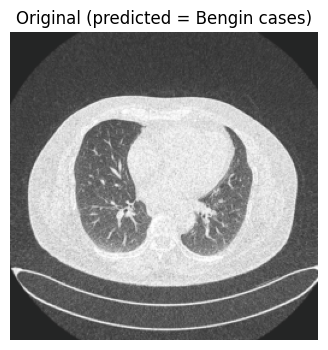

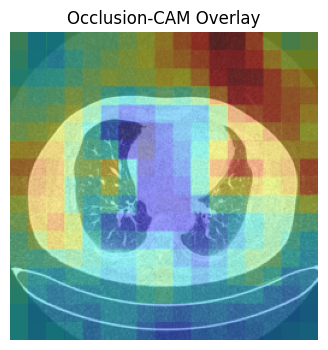

  0%|          | 0/200 [00:00<?, ?it/s]

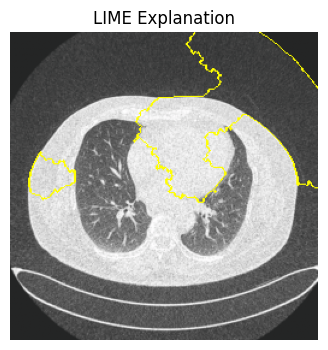

100%|██████████| 128/128 [00:11<00:00, 10.95it/s]


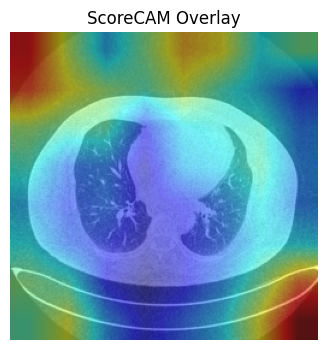


>>> XAI: vit_then_resnet


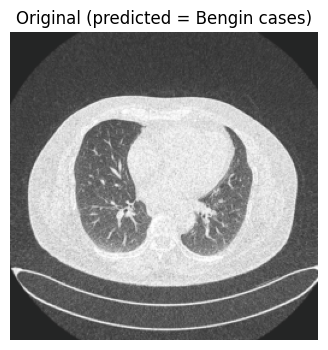

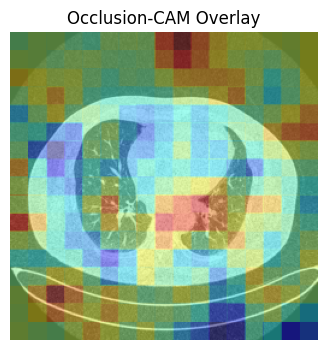

  0%|          | 0/200 [00:00<?, ?it/s]

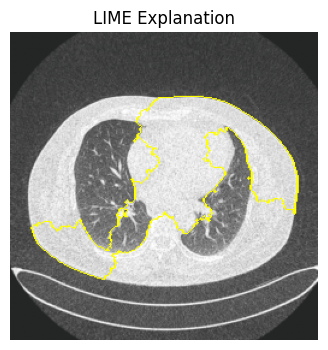

100%|██████████| 48/48 [00:05<00:00,  8.02it/s]


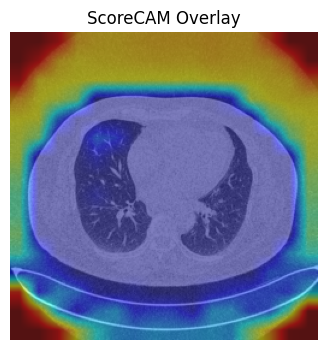


>>> XAI: swin_then_resnet


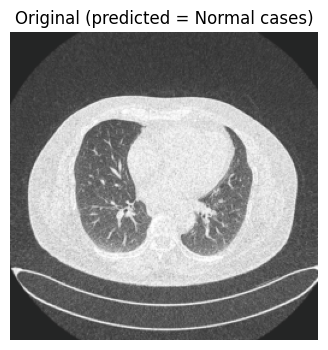

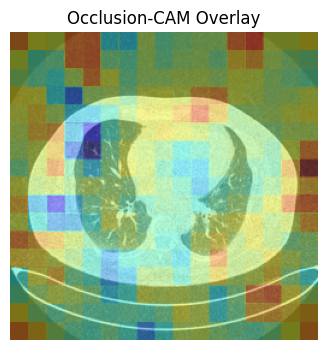

  0%|          | 0/200 [00:00<?, ?it/s]

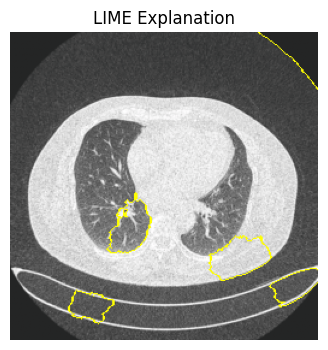

100%|██████████| 128/128 [00:13<00:00,  9.40it/s]


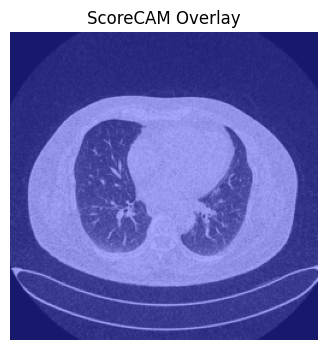


>>> XAI: swin_then_vit


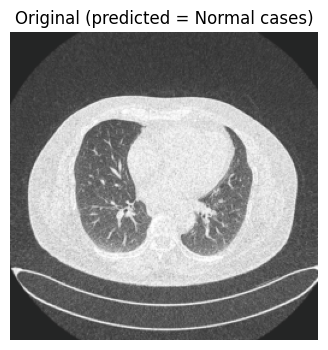

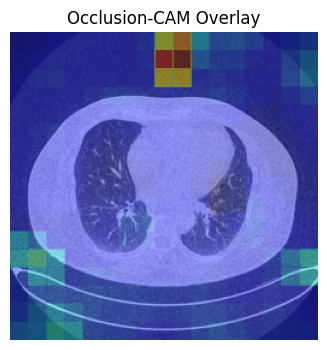

  0%|          | 0/200 [00:00<?, ?it/s]

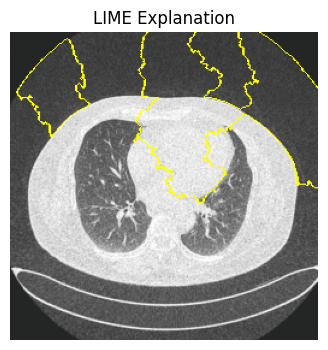

100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


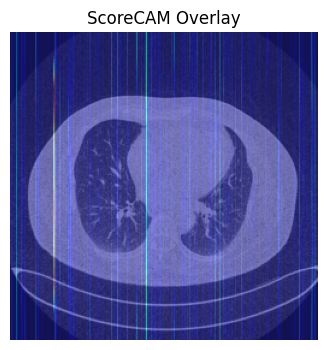


>>> XAI: resnet50_transfer


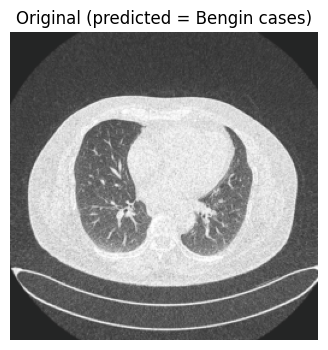

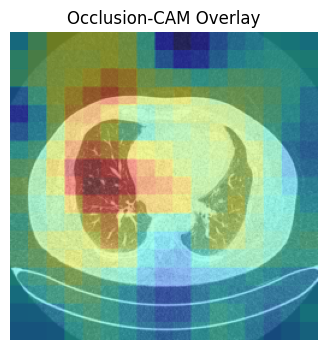

  0%|          | 0/200 [00:00<?, ?it/s]

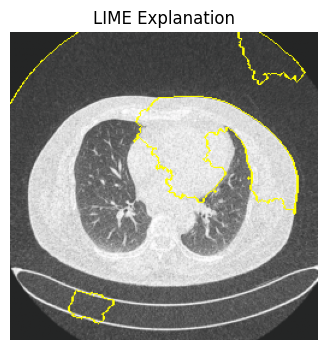

100%|██████████| 128/128 [00:07<00:00, 16.66it/s]


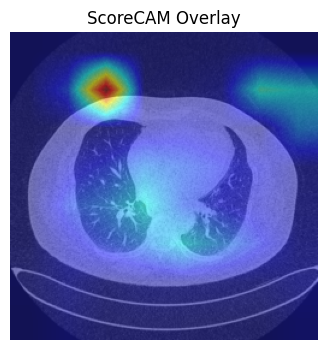


>>> XAI: densenet121_transfer


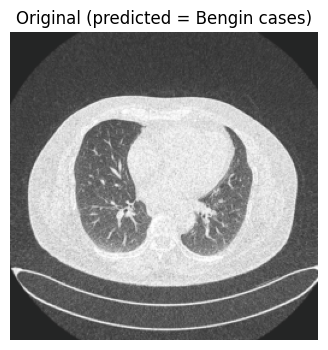

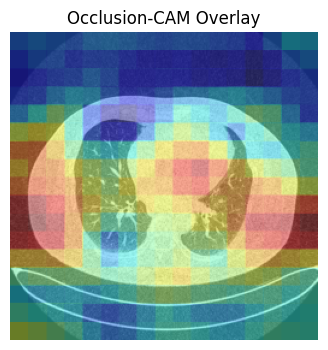

  0%|          | 0/200 [00:00<?, ?it/s]

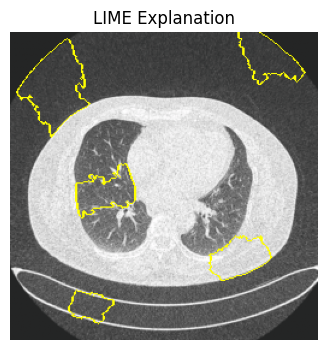

100%|██████████| 64/64 [00:03<00:00, 16.46it/s]


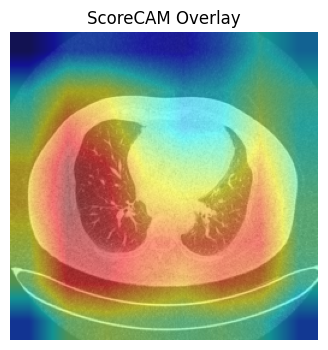


>>> XAI: efficientnet_b0_transfer


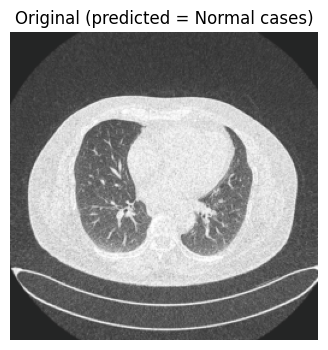

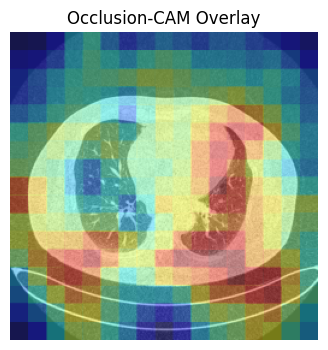

  0%|          | 0/200 [00:00<?, ?it/s]

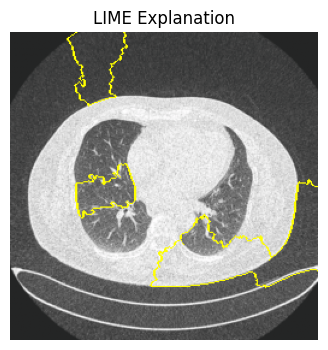

100%|██████████| 80/80 [00:02<00:00, 38.38it/s]


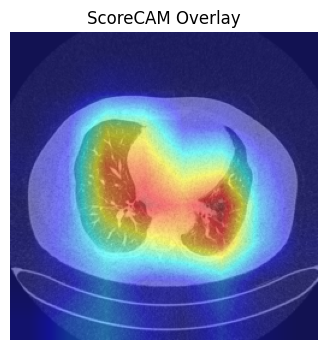


>>> XAI: vgg19_transfer


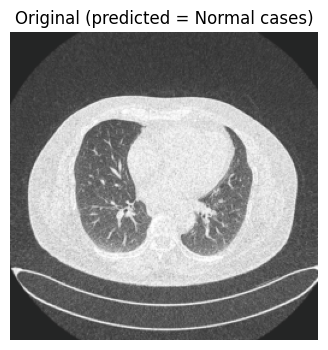

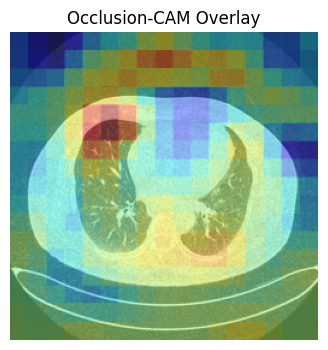

  0%|          | 0/200 [00:00<?, ?it/s]

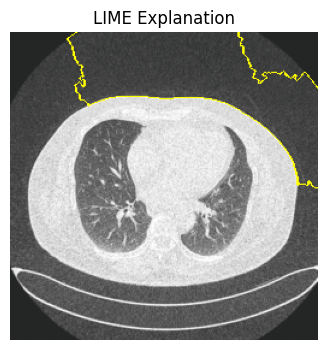

100%|██████████| 32/32 [00:03<00:00,  9.17it/s]


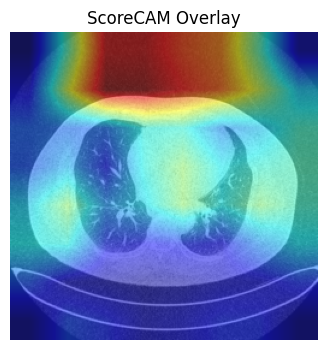


>>> XAI: swin_v2_transfer


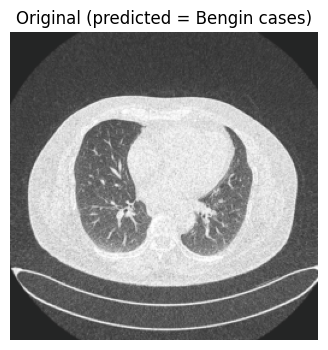

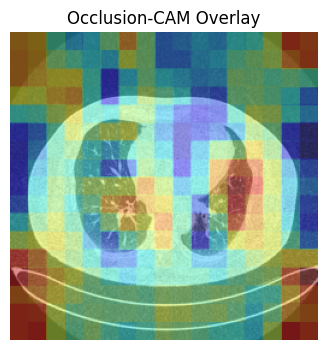

  0%|          | 0/200 [00:00<?, ?it/s]

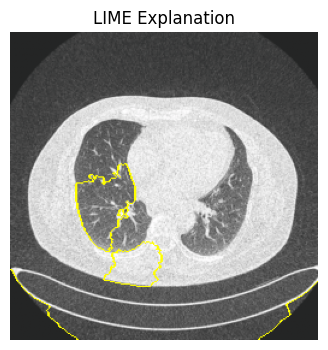

100%|██████████| 1/1 [00:00<00:00, 16.48it/s]


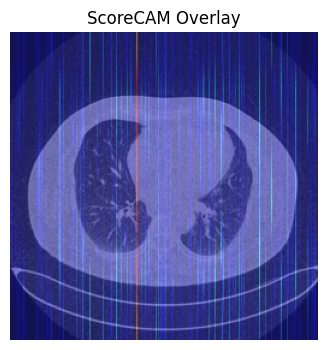

In [18]:
# =============================================================================
# 13) XAI for ALL models (complete code with fixed Occlusion upsampling)
# =============================================================================
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from captum.attr import Occlusion, visualization as viz
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import classification_report

# Assumes the following are already defined elsewhere in your notebook/script:
# MODEL_DICT, NUM_CLASSES, device, val_transform, val_loader, full_ds

def denormalize(tensor):
    """
    Denormalize a 3×HxW tensor (in PyTorch channel-first format) and return
    an H×Wx3 numpy array with pixel values in [0,1].
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = tensor.cpu() * std + mean
    return torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()

def predict_numpy(images, model):
    """
    Given a list of H×W×3 uint8 images (numpy), apply val_transform to each,
    stack them into a batch, run through `model`, and return softmax probabilities.
    """
    batch = [val_transform(Image.fromarray(img)) for img in images]
    batch = torch.stack(batch).to(device)
    with torch.no_grad():
        return torch.softmax(model(batch), dim=1).cpu().numpy()

for name, cls in MODEL_DICT.items():
    ckpt = f"{name}_best.pth"
    if not os.path.exists(ckpt):
        continue  # Skip this model if no checkpoint exists

    print(f"\n>>> XAI: {name}")
    # Load the model
    model = cls(num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()

    # Grab one minibatch from the validation loader
    imgs, labels = next(iter(val_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    pred_logits = model(imgs)
    pred_cls = pred_logits[0].argmax().item()

    # ----------------------------------------------------------------
    # 13.1 Occlusion (with upsampling + overlay)
    # ----------------------------------------------------------------

    # 1) Show the original denormalized image
    orig_img_np = denormalize(imgs[0])  # Shape: [H, W, 3] in [0, 1]
    plt.figure(figsize=(4,4))
    plt.imshow(orig_img_np)
    plt.title(f"Original (predicted = {full_ds.classes[pred_cls]})")
    plt.axis("off")
    plt.show()

    # 2) Compute Occlusion attribution on the single image
    occ = Occlusion(model)
    attr = occ.attribute(
        imgs[0].unsqueeze(0),              # Input shape: [1, 3, 256, 256]
        strides=(3, 15, 15),               # Slide in steps of 15 px horizontally/vertically
        sliding_window_shapes=(3, 31, 31), # Occlude 31×31 patches across all 3 channels
        baselines=0,
        target=pred_cls
    )
    # attr shape: [1, 3, out_H, out_W], where out_H ≈ (256 - 31) // 15 + 1, etc.

    # 3) Sum over the 3 channels to get a single-channel attribution mask
    attr_mask = attr.sum(dim=1, keepdim=True)  # Shape: [1, 1, out_H, out_W]

    # 4) Upsample from [out_H, out_W] to [256, 256]
    upsampled = F.interpolate(
        attr_mask,
        size=(256, 256),
        mode="bilinear",
        align_corners=False
    )  # Shape: [1, 1, 256, 256]

    # 5) Normalize the upsampled mask to [0,1] range
    heatmap = upsampled.squeeze().cpu().numpy()  # Shape: [256, 256]
    heatmap -= heatmap.min()
    heatmap /= (heatmap.max() + 1e-8)

    # 6) Convert heatmap into an RGB mask via a colormap (e.g., 'jet')
    cmap = plt.get_cmap("jet")
    colored_mask = cmap(heatmap)[:, :, :3]  # Shape: [256, 256, 3] in [0,1]

    # 7) Overlay: alpha-blend the original image and the colored mask
    alpha = 0.4
    overlay = (1.0 - alpha) * orig_img_np + alpha * colored_mask

    plt.figure(figsize=(4,4))
    plt.imshow(overlay)
    plt.title("Occlusion-CAM Overlay")
    plt.axis("off")
    plt.show()

    # ----------------------------------------------------------------
    # 13.2 LIME (explain only the predicted label)
    # ----------------------------------------------------------------

    # Prepare the image for LIME: convert denormalized [0,1] to [0,255] uint8
    img_for_lime = (orig_img_np * 255).astype("uint8")
    explainer = lime_image.LimeImageExplainer()
    exp = explainer.explain_instance(
        img_for_lime,
        lambda im: predict_numpy(im, model),
        labels=(pred_cls,),   # Force LIME to explain only the predicted class
        hide_color=0,
        num_samples=200
    )

    temp, mask = exp.get_image_and_mask(
        label=pred_cls,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    plt.figure(figsize=(4,4))
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title("LIME Explanation")
    plt.axis("off")
    plt.show()

    # ----------------------------------------------------------------
    # 13.3 ScoreCAM (hook into an appropriate convolutional layer)
    # ----------------------------------------------------------------

    # Choose a valid convolutional submodule (target_layer) for each model:
    if name == "resnet50_transfer":
        # ResNet50Transfer: the backbone is `model.model`, last block is layer4[-1]
        target_layer = model.model.layer4[-1]
    elif name == "densenet121_transfer":
        # DenseNet121Transfer: the backbone is `model.model.features`
        target_layer = model.model.features[-1]
    elif name == "efficientnet_b0_transfer":
        # EfficientNetB0Transfer: backbone is `model.model.features`
        target_layer = model.model.features[-1]
    elif name == "vgg19_transfer":
        # VGG19Transfer: backbone is `model.model.features`
        target_layer = model.model.features[-1]
    elif name == "swin_v2_transfer":
        # SwinV2Transfer: backbone is `model.model.features`
        target_layer = model.model.features[-1]
    elif name == "resnet_then_vit":
        # ResNetThenViT: `model.fe` is a Sequential of ResNet layers
        target_layer = model.fe[-1]
    elif name == "vit_then_resnet":
        # ViTThenResNet: the “patch embed” is `model.proj`
        target_layer = model.proj
    elif name == "swin_then_resnet":
        # SwinThenResNet: after swin.features→permute, feed into ResNet50
        target_layer = model.resnet.layer4[-1]
    elif name == "swin_then_vit":
        # SwinThenViT: `model.fe` is swin.features (channel-last then permuted)
        target_layer = model.fe[-1]
    else:
        # Fallback: take second-to-last child
        children = list(model.children())
        target_layer = children[-2]

    # Run ScoreCAM on the single image
    with ScoreCAM(model=model, target_layers=[target_layer]) as cam:
        gcam = cam(
            input_tensor=imgs[0].unsqueeze(0),
            targets=[ClassifierOutputTarget(pred_cls)]
        )[0]  # Shape: [256, 256]

    # Overlay ScoreCAM on top of original
    overlay2 = show_cam_on_image(
        orig_img_np,  # Denormalized original
        gcam,
        use_rgb=True
    )
    plt.figure(figsize=(4,4))
    plt.imshow(overlay2)
    plt.title("ScoreCAM Overlay")
    plt.axis("off")
    plt.show()


In [21]:
# =============================================================================
# 14) CNN + XGBoost + SHAP Pipeline (complete code)
# =============================================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm
import xgboost as xgb
import shap
from sklearn.metrics import classification_report

# Assumes the following are already defined elsewhere in your notebook/script:
#   device, train_loader, val_loader, NUM_CLASSES, full_ds

class CNNXGBoost:
    def __init__(self, feat_extractor):
        # feat_extractor: a torch.nn.Module that outputs feature vectors per image
        self.fe = feat_extractor.eval()
        self.xgb = None

    def extract(self, loader):
        """
        Given a DataLoader yielding (imgs, labels), returns:
          - feats: numpy array of shape [N_samples, feature_dim]
          - lbls:  numpy array of shape [N_samples]
        """
        feats_list, lbls_list = [], []
        with torch.no_grad():
            for imgs, labels in tqdm(loader, desc="Feat ext", leave=False):
                # imgs: [batch_size, 3, H, W]; labels: [batch_size]
                imgs = imgs.to(device)
                f = self.fe(imgs)                     # e.g. [batch_size, feat_dim, 1, 1]
                f = f.view(imgs.size(0), -1).cpu().numpy()  # [batch_size, feat_dim]
                feats_list.append(f)
                lbls_list.append(labels.numpy())
        feats = np.concatenate(feats_list, axis=0)
        lbls = np.concatenate(lbls_list, axis=0)
        return feats, lbls

    def fit(self, loader):
        """
        Extract features + labels from 'loader', then train an XGBoost classifier.
        """
        X, y = self.extract(loader)
        self.xgb = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=NUM_CLASSES,
            random_state=SEED
        )
        self.xgb.fit(X, y)

    def predict(self, imgs):
        """
        imgs: a torch.Tensor of shape [batch_size, 3, H, W]
        Returns: numpy array of predicted labels, shape [batch_size]
        """
        with torch.no_grad():
            f = self.fe(imgs.to(device)).view(imgs.size(0), -1).cpu().numpy()
        return self.xgb.predict(f)

    def predict_proba(self, imgs):
        """
        imgs: a torch.Tensor of shape [batch_size, 3, H, W]
        Returns: numpy array of class probabilities, shape [batch_size, NUM_CLASSES]
        """
        with torch.no_grad():
            f = self.fe(imgs.to(device)).view(imgs.size(0), -1).cpu().numpy()
        return self.xgb.predict_proba(f)

# -----------------------------------------------------------------------------
# 14.1 Prepare the CNN feature extractor
# -----------------------------------------------------------------------------
# We take a pretrained ResNet50 and strip off the final fully‐connected layer.
# The remaining feature extractor ends with a global‐pool that gives [batch, 2048, 1, 1].
cnn_feat = nn.Sequential(
    *list(models.resnet50(pretrained=True).children())[:-1]
).to(device)

# -----------------------------------------------------------------------------
# 14.2 Instantiate and train the CNN+XGB pipeline
# -----------------------------------------------------------------------------
pipeline = CNNXGBoost(cnn_feat)
pipeline.fit(train_loader)


CNN+XGB Validation Accuracy: 0.8606



ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

In [ ]:

# -----------------------------------------------------------------------------
# 14.3 Validate CNN+XGBoost on the validation set (with dynamic class handling)
# -----------------------------------------------------------------------------
all_preds, all_labels = [], []
for imgs, lbls in tqdm(val_loader, desc="CNN+XGB Val", leave=False):
    preds_batch = pipeline.predict(imgs)  # returns numpy array of shape [batch_size]
    all_preds.extend(preds_batch.tolist())
    all_labels.extend(lbls.numpy().tolist())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
val_acc = np.mean(all_preds == all_labels)
print(f"CNN+XGB Validation Accuracy: {val_acc:.4f}\n")

# Compute which class indices actually appear in all_labels
unique_labels = sorted(set(all_labels))
# Get their human‐readable names from full_ds.classes
used_class_names = [full_ds.classes[idx] for idx in unique_labels]

print(classification_report(
    all_labels,
    all_preds,
    labels=unique_labels,
    target_names=used_class_names,
    zero_division=0
))

# -----------------------------------------------------------------------------
# 14.4 SHAP Explanation for one validation example
# -----------------------------------------------------------------------------
# 1) Build a small “background” dataset from training features (max 50 samples):
Xbg, _ = pipeline.extract(train_loader)
n_bg = min(50, Xbg.shape[0])
bg_idx = np.random.choice(Xbg.shape[0], n_bg, replace=False)
background = Xbg[bg_idx]  # shape: [n_bg, feat_dim]

# 2) Create a SHAP explainer for the trained XGB classifier:
explainer = shap.Explainer(pipeline.xgb, background)

# 3) Pick one batch from val_loader, extract features for the first image:
sample_imgs, _ = next(iter(val_loader))
sample_imgs = sample_imgs.to(device)
with torch.no_grad():
    sample_feats = cnn_feat(sample_imgs).view(sample_imgs.size(0), -1).cpu().numpy()
# Use only the first validation sample for SHAP:
sample_feat_vector = sample_feats[0:1]  # shape: [1, feat_dim]

# 4) Compute SHAP values for that single feature vector:
shap_values = explainer(sample_feat_vector)  # returns a list of shap value objects

# 5) Visualize SHAP force plot and waterfall plot:
shap.initjs()
print("SHAP force plot for the first validation example:")
shap.plots.force(shap_values[0])

print("SHAP waterfall plot for the first validation example:")
shap.plots.waterfall(shap_values[0])


CNN+XGB Validation Accuracy: 0.8606

                 precision    recall  f1-score   support

   Bengin cases       0.46      0.72      0.57        18
Malignant cases       0.94      0.99      0.97        84
   Normal cases       0.94      0.73      0.82        63

       accuracy                           0.86       165
      macro avg       0.78      0.81      0.78       165
   weighted avg       0.89      0.86      0.87       165



Feat ext:  46%|████▋     | 348/750 [00:22<00:24, 16.46it/s]